In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lasio
import os
import glob
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from fastdtw import fastdtw
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from geopy.distance import geodesic
import networkx as nx
import scipy.interpolate
import time

In [23]:
# directory on personal computer
ruta = 'C:/Users/User/Desktop/Pan American Energy/reference scripts/initial'
os.chdir(ruta)

ruta_logs = ruta + "/Perfiles_3"
las_files = glob.glob(os.path.join(ruta_logs, '*.las'))

logs = {}

# Function to calculate geodesic distance between two points
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters

# Create a directed graph
G = nx.DiGraph()

# Set the separation distance between nodes
separation_distance = 2

# Reference latitude and longitude (you may want to set this based on your specific location)
reference_latitude = 0
reference_longitude = 0

# Create nodes in a grid layout and connect nodes within 200 meters
for i, las_file in enumerate(las_files):
    las = lasio.read(las_file)
    las_df = las.df().dropna()
    las_df = las_df.reset_index()

    # Calculate position in a grid layout
    rows = int(len(las_files)**0.5)
    cols = int(np.ceil(len(las_files) / rows))
    x = (i % rows) * separation_distance
    y = (i // rows) * separation_distance
    
    # Calculate latitude and longitude based on grid position
    latitude = reference_latitude + y * (1 / 111000)  # Approximately, latitude degrees per meter
    longitude = reference_longitude + x * (1 / (111000 * np.cos(np.radians(reference_latitude))))  # Approximately, longitude degrees per meter
    
    # Add node to the graph with the file name as the node name
    node_name = os.path.splitext(os.path.basename(las_file))[0]
    G.add_node(node_name, data=las_df, latitude=latitude, longitude=longitude, pos=(x, y))


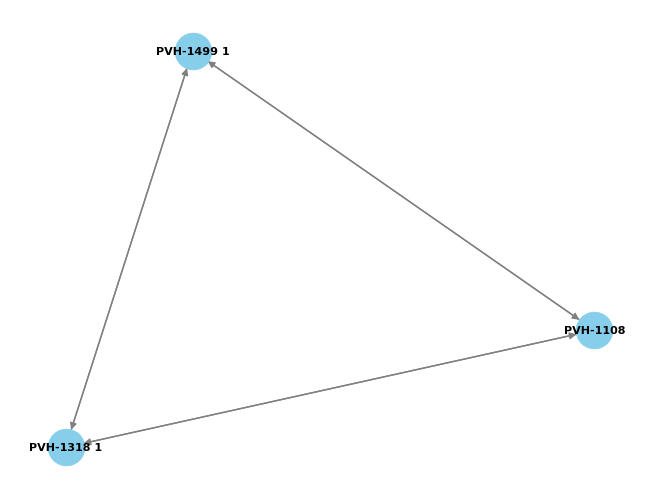

In [24]:
#%%
# Remove all connections (edges) from the graph
G.clear_edges()
# Connect nodes within 200 meters
for node_i, data_i in G.nodes(data=True):
    for node_j, data_j in G.nodes(data=True):
        if node_i != node_j:  # Avoid self-loops
            distance = calculate_distance(data_i['latitude'], data_i['longitude'],
                                          data_j['latitude'], data_j['longitude'])
            if distance < 4: #3
                G.add_edge(node_i, node_j)

# Draw the graph
plt.figure()
# pos = nx.get_node_attributes(G, 'pos')
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue',
        font_size=8, font_color='black', font_weight='bold',
        arrowsize=10, edge_color='gray', linewidths=0.5)

#plt.title('Grid Layout with Connections within 200m')
plt.show()

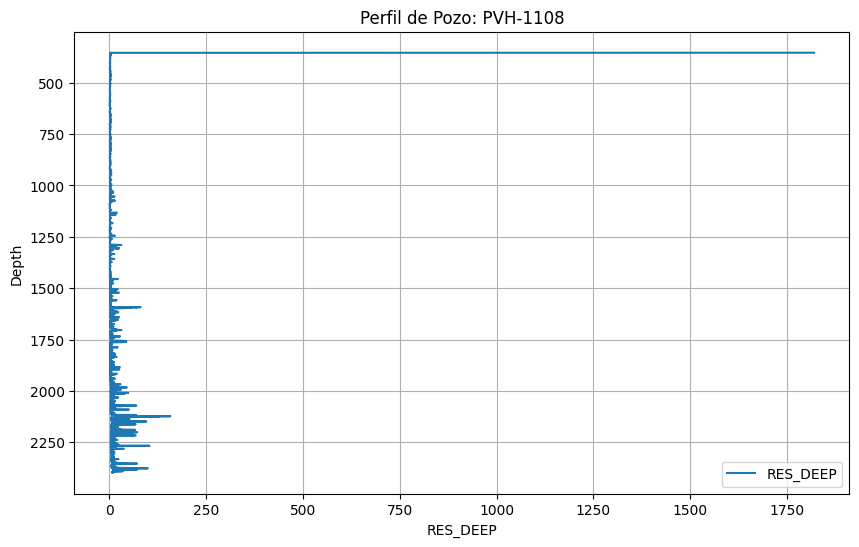

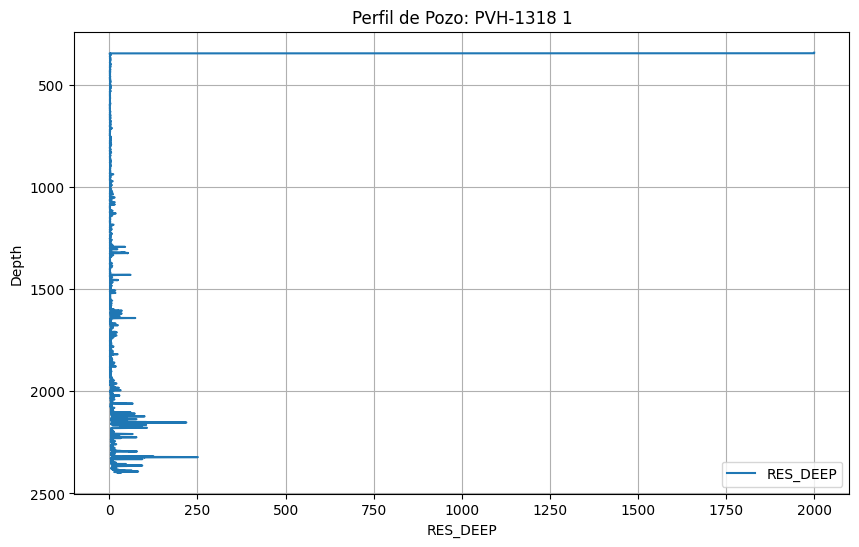

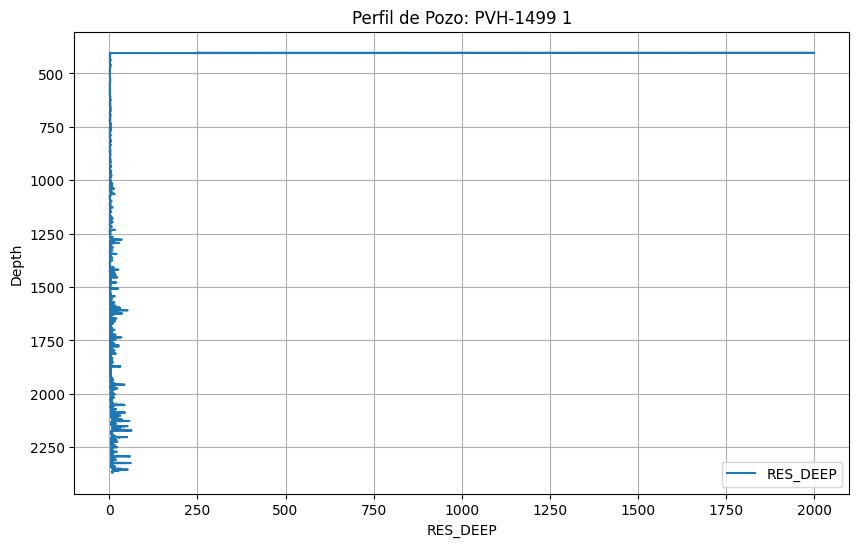

In [25]:
def getProfile(G, node):
    
    data = G.nodes[node]['data']
    
    plt.figure(figsize=(10, 6))
    for column in data.columns:
        if column != 'DEPTH':
            plt.plot(data[column], data['DEPTH'], label=column)
    
    plt.gca().invert_yaxis()
    plt.xlabel('RES_DEEP')
    plt.ylabel('Depth')
    plt.title(f'Perfil de Pozo: {node}')
    plt.legend()
    plt.grid(True)
    plt.show()


for node in G:
    getProfile(G, node)

Identify Tops
Note: this seems to only work when current node "pozo" is 1318 1

In [26]:
ruta_archivo = ruta_logs +"/Capas O PVH-1318_PVH-1499.xls"

# Leer el archivo usando pandas
tops = pd.read_excel(ruta_archivo)
tops=tops[tops["Pozo"]=="PVH-1318"]
a = tops.loc[tops["Pozo"] == "PVH-1318", ["Pozo", "Capa", "Tope"]]
a.rename(columns={"Tope": "Ref"}, inplace=True)

b=tops.loc[tops["Pozo"] == "PVH-1318", ["Pozo", "Capa", "Base"]]
b.rename(columns={"Base": "Ref"}, inplace=True)
resultado = pd.concat([a, b], ignore_index=True)
tops=resultado
# Mostrar las primeras filas del DataFrame para verificar la lectura
print(tops.head())


plt.show()

G.nodes['PVH-1318 1']["tops"]=tops

       Pozo  Capa        Ref
0  PVH-1318   O4T  1600.6632
1  PVH-1318   O5T  1614.4039
2  PVH-1318  O5aT  1624.3099
3  PVH-1318  O5bT  1630.0619
4  PVH-1318   O7T  1639.0092


Finally using DTW Algorithm, can start from here.

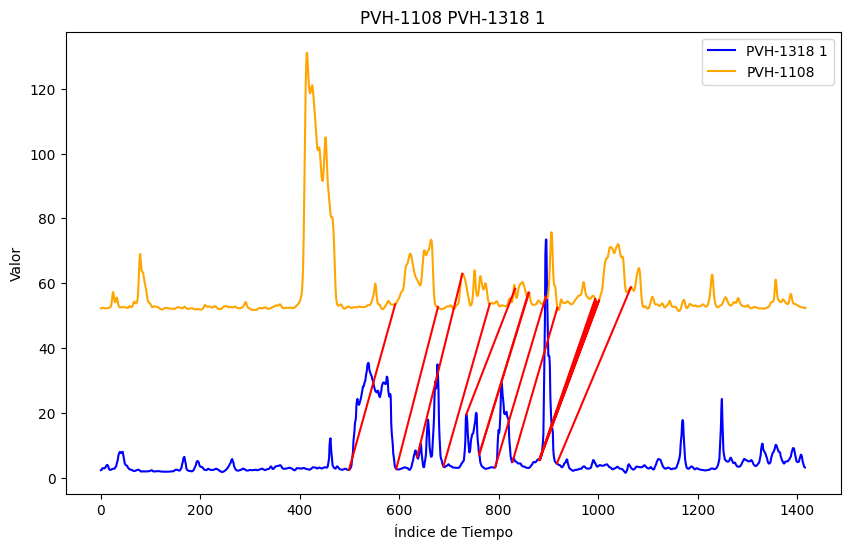

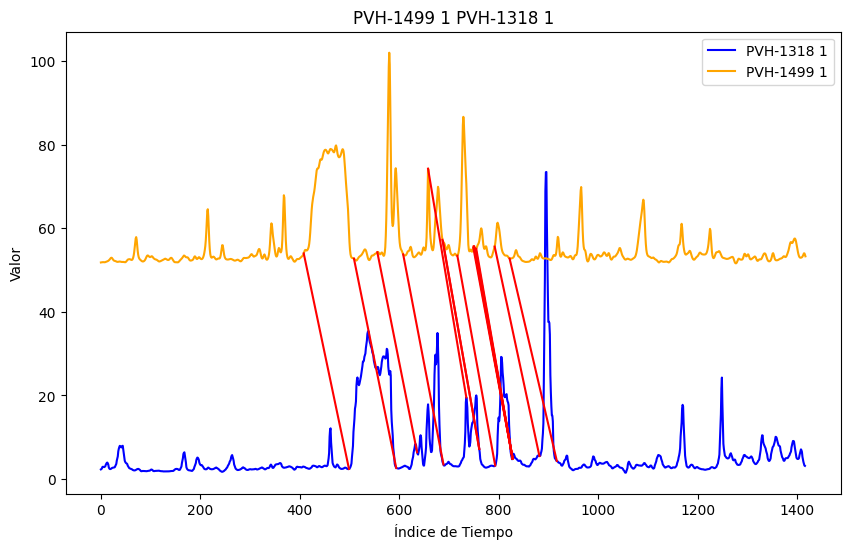

In [30]:

# only works when this is current node, need to make this more universal
pozo='PVH-1318 1'

def normalize_array(arr):
    reshaped_arr = arr.reshape(-1, 1)
    scaler = MinMaxScaler()
    normalized_arr = scaler.fit_transform(reshaped_arr)
    return normalized_arr

def custom_distance(p1, p2):
    return np.abs(p1 - p2) **(1/ 4.1)


neighbors = list(G.successors(pozo))
tolerance = 0.05
df1 = G.nodes[pozo]["data"]
tops = G.nodes[pozo]["tops"]
df1['Present'] = 0 #New column to mark the presence of tops
logs = [df1] #iterable of log dataframes, need to add in for loop

for nodo in neighbors:
    df2 = G.nodes[nodo]["data"]

    for index_df1, row_df1 in df1.iterrows():
        depth_value = row_df1['DEPTH']
        matches = tops['Ref'].apply(lambda x: np.abs(x - depth_value) <= tolerance)
        if matches.any():
            df1.at[index_df1, 'Present'] = 1 #mark rows within the tolerance range of any top

    #print(df1.head(10))

    #Filter df1 and df2 to only include depths around tops
    G.nodes[pozo]["topes"] = df1[df1['Present'] == 1]
    prof1 = df1[df1['Present'] == 1]["DEPTH"].reset_index()["DEPTH"][0] - 50
    prof2 = df1[df1['Present'] == 1]["DEPTH"].reset_index()["DEPTH"].iloc[-1] + 50
    df1 = df1[(df1['DEPTH'] > prof1) & (df1['DEPTH'] < prof2)].reset_index()
    df2 = df2[(df2['DEPTH'] > prof1) & (df2['DEPTH'] < prof2)].reset_index()

    # normalize res deep in df1 and df2
    w1 = np.array(df1['RES_DEEP'].dropna())
    w1_normalized = normalize_array(w1)
    df1['w1_normalized'] = w1_normalized

    w2 = np.array(df2['RES_DEEP'].dropna())
    w2_normalized = normalize_array(w2)

    #DTW Distance
    ref = df1[df1["Present"] == 1]
    distance, path = fastdtw(w1, w2, dist=custom_distance)
    correla = [tupla for tupla in path if tupla[0] in ref.index]
    correla2 = [tupla[1] for tupla in correla]

    #mark tops in df2
    df2["topes"] = 0
    for elemento in correla2:
        if elemento in df2.index:
            df2.loc[elemento, "topes"] = 1
    G.nodes[nodo]["topes"] = df2[df2["topes"] == 1]
    G.nodes[nodo]["Procesados"] = df2

    logs.append(df2)

    offset = 50
    plt.figure(figsize=(10, 6))
    plt.plot(df1["RES_DEEP"], label=pozo, color='blue')
    plt.plot(df2["RES_DEEP"] + offset, label=nodo, color='orange')
    for i, j in correla:
        plt.plot([i, j], [df1["RES_DEEP"].iloc[i], df2["RES_DEEP"].iloc[j] + offset], color='red', linestyle='-')
    plt.title(nodo + " " + pozo)
    plt.xlabel('Índice de Tiempo')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()
